# Pseudobulk differential expression to compare WT BRZ vs WT Control

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(muscat)
library(purrr)
library(limma)
library(scran)
library(future)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex hea

In [2]:
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
rc.integrated <- readRDS("../data/integrations/rc.integrated_15S_BRZ_bri1_Li_seu3_clean.rds")

In [4]:
rc.integrated

An object of class Seurat 
71252 features across 78435 samples within 3 assays 
Active assay: integrated (17338 features, 17338 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

## Cell type and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`
- Combination of cell type and developmental stage with cell subtypes (not used): `time_zone_cell_subtypes` 

In [5]:
feature_names <- read_tsv("./data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


── Column specification ────────────────────────────────────────────────────────
cols(
  AGI = col_character(),
  Name = col_character(),
  Type = col_character()
)




In [6]:
table(rc.integrated$treatment, rc.integrated$sample)

         
          sc_111 sc_112 sc_113 sc_114 sc_130 sc_131 sc_132 sc_133 sc_134 sc_135
  BRZ          0   6947      0   7373      0      0      0      0      0      0
  Control   7449      0   9193      0   6589   7621   6550   5975   7745   5028
         
          sc_136 sc_137
  BRZ          0      0
  Control   6062   1903

# Differential State Analysis with Muscat

In [7]:
# subset samples you want to compare

integrated.de <- subset(rc.integrated, subset = sample %in% c( "sc_111", "sc_113","sc_112","sc_114"))


In [8]:
integrated.de

An object of class Seurat 
71252 features across 30962 samples within 3 assays 
Active assay: integrated (17338 features, 17338 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

In [9]:
# code control vs treated manually

integrated.de$treated <- integrated.de$treatment %in% c("BRZ")

integrated.de$treatment <- as.character(integrated.de$treated)

integrated.de$treatment<- gsub("TRUE", "BRZ", integrated.de$treatment, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)
  
integrated.de$treatment<- gsub("FALSE", "Control", integrated.de$treatment, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

integrated.de$treatment <- factor(integrated.de$treatment, levels=c("Control", "BRZ"))

table(integrated.de$treatment)
table(integrated.de$treatment, integrated.de$sample)


Control     BRZ 
  16642   14320 

         
          sc_111 sc_112 sc_113 sc_114
  Control   7449      0   9193      0
  BRZ          0   6947      0   7373

## Convert to sce

In [10]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$sample,
                              group_id = integrated.de$treatment,
                              cluster_id = integrated.de$time_zone_cell_type, 
                             date=integrated.de$rep) # include experimental rep as co-variate

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

In [11]:
    (sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 29347 30962 
metadata(1): experiment_info
assays(1): counts
rownames(29347): AT1G01010 AT1G01020 ... AT5G53640 AT5G60260
rowData names(0):
colnames(30962): AAACCCAAGCTGACCC_4 AAACCCAAGGTGCGAT_4 ...
  TTTGTTGTCATGTCAG_7 TTTGTTGTCGAAACAA_7
colData names(4): cluster_id sample_id group_id date
reducedDimNames(0):
altExpNames(0):

## pre-filtering

In [12]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 26790 30962

In [13]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 22449 30962

In [14]:
# create pseudobulk profiles
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "Distal Columella"                     
 [2] "Distal Lateral Root Cap"              
 [3] "Elongation_Atrichoblast"              
 [4] "Elongation_Cortex"                    
 [5] "Elongation_Endodermis"                
 [6] "Elongation_Pericycle"                 
 [7] "Elongation_Phloem"                    
 [8] "Elongation_Procambium"                
 [9] "Elongation_Trichoblast"               
[10] "Elongation_Xylem"                     
[11] "Maturation_Atrichoblast"              
[12] "Maturation_Cortex"                    
[13] "Maturation_Endodermis"                
[14] "Maturation_Pericycle"                 
[15] "Maturation_Phloem"                    
[16] "Maturation_Procambium"                
[17] "Maturation_Trichoblast"               
[18] "Maturation_Xylem"                     
[19] "Proliferation Domain_Atrichoblast"    
[20] "Proliferation Domain_Cortex"          
[21] "Proliferation Domain_Endodermis"      
[22] "Proliferation Domain_Pericycle"       
[23] "Proliferation Domain_Procambium"      
[24] "Proliferation Domain_Quiescent Center"
[25] "Proliferation Domain_Trichoblast"     
[26] "Proliferation Domain_Xylem"           
[27] "Proximal Columella"                   
[28] "Proximal Lateral Root Cap"            
[29] "Transition Domain_Atrichoblast"       
[30] "Transition Domain_Cortex"             
[31] "Transition Domain_Endodermis"         
[32] "Transition Domain_Pericycle"          
[33] "Transition Domain_Phloem"             
[34] "Transition Domain_Trichoblast"        
[35] "Transition Domain_Xylem"

In [15]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060
sc_111,9,36,5,9,962,3
sc_112,9,51,11,12,769,2
sc_113,19,52,13,7,681,2
sc_114,20,57,14,19,759,5


In [16]:
bscs <- read.csv("./data/GEO_upload_BR_time_scRNA_samples_metadata.csv", na.strings=c("","NA"), stringsAsFactors = F)
bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)

bscs

sample,name,genotype,full_genotype,treatment,concentration,age,timepoint,time_trt,rep,date,seq_run,X10X_chemistry
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>
sc_1,WT control,WT,WT Col-0,Control,DMSO,7_day,NA,Control,1,2019-12-14,Nolan_6131,v3
sc_2,WT BRZ control,WT,WT Col-0,BRZ,1uM,7_day,0.0,BRZ,1,2019-12-14,Nolan_6131,v3
sc_5,WT BRZ then 2 hour BL,WT,WT Col-0,BL,100nM,7_day,2.0,2_hour_BL,1,2019-12-14,Nolan_6131,v3
sc_43,WT BRZ control,WT,WT Col-0,BRZ,1uM,7_day,0.0,BRZ,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3
sc_44,WT BRZ then 30 mins BL,WT,WT Col-0,BL,100nM,7_day,0.5,0.5_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3
sc_45,WT BRZ then 1 hour BL,WT,WT Col-0,BL,100nM,7_day,1.0,1_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3
sc_46,WT BRZ then 2 hour BL,WT,WT Col-0,BL,100nM,7_day,2.0,2_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3
sc_47,WT BRZ then 4 hour BL,WT,WT Col-0,BL,100nM,7_day,4.0,4_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3
sc_48,WT BRZ then 8 hour BL,WT,WT Col-0,BL,100nM,7_day,8.0,8_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3


In [17]:
# experiment info for contrasts, add dates from csv

ei <- metadata(sce)$experiment_info


#block for replicate
sample_date <- select(bscs, sample_id=sample, date=rep)

ei <- left_join(ei, sample_date)

ei

Joining, by = "sample_id"



sample_id,group_id,n_cells,date
<chr>,<fct>,<dbl>,<int>
sc_111,Control,7449,1
sc_112,BRZ,6947,1
sc_113,Control,9193,2
sc_114,BRZ,7373,2


In [18]:
mm <- model.matrix(~ 0 + ei$group_id + ei$date)
dimnames(mm) <- list(ei$sample_id, c(levels(ei$group_id), "date"))

mm

,Control,BRZ,date
sc_111,1,0,1
sc_112,0,1,1
sc_113,1,0,2
sc_114,0,1,2


In [19]:
contrast <- makeContrasts("BRZ-Control", levels = mm)

contrast

,BRZ-Control
Control,-1
BRZ,1
date,0


In [20]:
res <- pbDS(pb, design = mm, 
            contrast = contrast, 
            method="edgeR", 
            min_cells=5, 
            filter = c("none"))

Distal Columella..Distal Lateral Root Cap..Elongation_Atrichoblast..Elongation_Cortex..Elongation_Endodermis..Elongation_Pericycle..Elongation_Phloem..Elongation_Procambium..Elongation_Trichoblast..Elongation_Xylem..Maturation_Atrichoblast..Maturation_Cortex..Maturation_Endodermis..Maturation_Pericycle..Maturation_Phloem..Maturation_Procambium..Maturation_Trichoblast..Maturation_Xylem..Proliferation Domain_Atrichoblast..Proliferation Domain_Cortex..Proliferation Domain_Endodermis..Proliferation Domain_Pericycle..Proliferation Domain_Procambium..Proliferation Domain_Quiescent Center..Proliferation Domain_Trichoblast..Proliferation Domain_Xylem..Proximal Columella..Proximal Lateral Root Cap..Transition Domain_Atrichoblast..Transition Domain_Cortex..Transition Domain_Endodermis..Transition Domain_Pericycle..Transition Domain_Phloem..Transition Domain_Trichoblast..Transition Domain_Xylem..

### DEG results

In [21]:
# DEG results with gene freqs
(res_to_write_frq <- resDS(sce, res, bind = "row", cpm=TRUE, frq=T))

gene,cluster_id,sc_111.cpm,sc_113.cpm,sc_112.cpm,sc_114.cpm,sc_111.frq,sc_113.frq,sc_112.frq,sc_114.frq,Control.frq,BRZ.frq,logFC,logCPM,F,p_val,p_adj.loc,p_adj.glb,contrast
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AT1G01010,Distal Columella,3.070,4.020,2.690,3.120,0.01690,0.03730,0.01470,0.02740,0.02750,0.021600,-0.30000,1.9000,4.99e-01,4.80e-01,0.880000,1,BRZ-Control
AT1G01020,Distal Columella,12.300,11.000,15.300,8.900,0.07200,0.09410,0.07490,0.07670,0.08350,0.075900,-0.01990,3.5800,7.33e-03,9.32e-01,0.981000,1,BRZ-Control
AT1G01030,Distal Columella,1.700,2.750,3.290,2.190,0.01060,0.02160,0.01790,0.01780,0.01630,0.017900,0.15400,1.5500,9.29e-02,7.60e-01,0.951000,1,BRZ-Control
AT1G01040,Distal Columella,3.070,1.480,3.590,2.970,0.01690,0.01370,0.01950,0.02470,0.01530,0.022300,0.61900,1.6600,1.62e+00,2.03e-01,0.675000,1,BRZ-Control
AT1G01050,Distal Columella,328.000,144.000,230.000,118.000,0.75800,0.61000,0.56800,0.56700,0.68100,0.568000,-0.39700,7.6700,9.53e+00,2.02e-03,0.027500,1,BRZ-Control
AT1G01060,Distal Columella,1.020,0.423,0.599,0.780,0.00636,0.00392,0.00326,0.00685,0.00509,0.005210,0.12800,0.2000,1.09e-02,9.17e-01,0.981000,1,BRZ-Control
AT1G01070,Distal Columella,1.020,0.845,0.000,0.000,0.00636,0.00588,0.00000,0.00000,0.00611,0.000000,-5.03000,-0.2110,4.26e+00,3.89e-02,0.257000,1,BRZ-Control
AT1G01080,Distal Columella,0.000,0.845,0.000,0.624,0.00000,0.00784,0.00000,0.00548,0.00407,0.002980,-0.40900,-0.1270,6.05e-02,8.06e-01,0.969000,1,BRZ-Control
AT1G01090,Distal Columella,34.100,34.900,27.500,36.800,0.18900,0.25700,0.12900,0.26700,0.22400,0.204000,-0.08210,5.0900,2.55e-01,6.14e-01,0.897000,1,BRZ-Control


In [22]:
## all genes background 

all_bg <- filter(res_to_write_frq,
                BRZ.frq >=0.1 | Control.frq >=0.1)

In [23]:
length(unique(all_bg$gene))

[1] 17696

In [24]:
#total DE genes p_adj.loc < 0.05, abs(logFC) > 1.5
sig_DE <- filter(res_to_write_frq, p_adj.loc<=0.05 & abs(logFC) > log2(1.5))
sig_DE <- left_join(sig_DE, feature_names, by=c("gene"="AGI"))

length(unique(sig_DE$gene))

[1] 8298

In [25]:
# filter gene freqs to avoid calling lowly detected genes
sig_DE_fil <- filter(sig_DE, BRZ.frq >=0.1 | Control.frq >=0.1)

In [26]:
length(unique(sig_DE_fil$gene))

[1] 6928

In [27]:
# load TFs
TF_list <- read_csv("./data/Kay_TF_thalemine_annotations.csv", col_names = c("gene", "TF_Name", "Description")) 


── Column specification ────────────────────────────────────────────────────────
cols(
  gene = col_character(),
  TF_Name = col_character(),
  Description = col_character()
)




In [28]:
sig_DE_fil <- left_join(sig_DE_fil, TF_list)

Joining, by = "gene"



In [29]:
# label up vs down
sig_DE_fil <- sig_DE_fil %>%
  mutate(up_dn_label = case_when(logFC >=log2(1.5) ~ "Up",  
                                       logFC <=log2(1/1.5) ~ "Down",
                                       TRUE ~ "Not DE"))

sig_DE_fil$clust_up_dn <- paste(sig_DE_fil$cluster_id, sig_DE_fil$up_dn_label, sep="_")

sig_DE_fil

gene,cluster_id,sc_111.cpm,sc_113.cpm,sc_112.cpm,sc_114.cpm,sc_111.frq,sc_113.frq,sc_112.frq,sc_114.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01140,Distal Columella,9.20,20.5,4.19,10.50,0.0530,0.1590,0.0228,0.0877,⋯,17.70,2.56e-05,6.68e-04,1.00e+00,BRZ-Control,CIPK9,NA,NA,Down,Distal Columella_Down
AT1G01260,Distal Columella,17.70,24.7,38.90,30.10,0.1020,0.2040,0.1760,0.2210,⋯,13.60,2.22e-04,4.26e-03,1.00e+00,BRZ-Control,BHLH13,AT1G01260,basic helix-loop-helix (bHLH) DNA-binding superfamily protein,Up,Distal Columella_Up
AT1G01580,Distal Columella,42.30,55.2,16.80,33.70,0.2200,0.3410,0.0831,0.2320,⋯,33.70,6.52e-09,3.47e-07,3.61e-03,BRZ-Control,FRO2,NA,NA,Down,Distal Columella_Down
AT1G02000,Distal Columella,32.70,57.1,58.40,79.00,0.1780,0.3690,0.2380,0.4560,⋯,16.00,6.20e-05,1.42e-03,1.00e+00,BRZ-Control,GAE2,NA,NA,Up,Distal Columella_Up
AT1G02920,Distal Columella,67.80,190.0,228.00,402.00,0.1190,0.1610,0.2560,0.2960,⋯,111.00,8.34e-26,2.85e-23,4.65e-20,BRZ-Control,GSTF7,NA,NA,Up,Distal Columella_Up
AT1G02930,Distal Columella,29.30,77.6,117.00,215.00,0.1140,0.1860,0.2540,0.3850,⋯,130.00,4.35e-30,2.35e-27,2.42e-24,BRZ-Control,GSTF6,NA,NA,Up,Distal Columella_Up
AT1G03070,Distal Columella,20.40,45.4,54.50,75.90,0.1020,0.2750,0.1990,0.3630,⋯,39.00,4.43e-10,2.92e-08,2.46e-04,BRZ-Control,LFG4,NA,NA,Up,Distal Columella_Up
AT1G03080,Distal Columella,103.00,93.0,172.00,179.00,0.4260,0.5350,0.5590,0.7010,⋯,38.60,5.34e-10,3.47e-08,2.97e-04,BRZ-Control,NET1D,NA,NA,Up,Distal Columella_Up
AT1G04180,Distal Columella,21.10,21.6,10.50,9.21,0.0932,0.1550,0.0326,0.0534,⋯,28.40,9.89e-08,4.26e-06,5.47e-02,BRZ-Control,YUC9,NA,NA,Down,Distal Columella_Down


In [30]:
sig_DE_fil
write.csv(sig_DE_fil, file = "./output/v4_BRZ_v_Control_cell_time_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")

gene,cluster_id,sc_111.cpm,sc_113.cpm,sc_112.cpm,sc_114.cpm,sc_111.frq,sc_113.frq,sc_112.frq,sc_114.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01140,Distal Columella,9.20,20.5,4.19,10.50,0.0530,0.1590,0.0228,0.0877,⋯,17.70,2.56e-05,6.68e-04,1.00e+00,BRZ-Control,CIPK9,NA,NA,Down,Distal Columella_Down
AT1G01260,Distal Columella,17.70,24.7,38.90,30.10,0.1020,0.2040,0.1760,0.2210,⋯,13.60,2.22e-04,4.26e-03,1.00e+00,BRZ-Control,BHLH13,AT1G01260,basic helix-loop-helix (bHLH) DNA-binding superfamily protein,Up,Distal Columella_Up
AT1G01580,Distal Columella,42.30,55.2,16.80,33.70,0.2200,0.3410,0.0831,0.2320,⋯,33.70,6.52e-09,3.47e-07,3.61e-03,BRZ-Control,FRO2,NA,NA,Down,Distal Columella_Down
AT1G02000,Distal Columella,32.70,57.1,58.40,79.00,0.1780,0.3690,0.2380,0.4560,⋯,16.00,6.20e-05,1.42e-03,1.00e+00,BRZ-Control,GAE2,NA,NA,Up,Distal Columella_Up
AT1G02920,Distal Columella,67.80,190.0,228.00,402.00,0.1190,0.1610,0.2560,0.2960,⋯,111.00,8.34e-26,2.85e-23,4.65e-20,BRZ-Control,GSTF7,NA,NA,Up,Distal Columella_Up
AT1G02930,Distal Columella,29.30,77.6,117.00,215.00,0.1140,0.1860,0.2540,0.3850,⋯,130.00,4.35e-30,2.35e-27,2.42e-24,BRZ-Control,GSTF6,NA,NA,Up,Distal Columella_Up
AT1G03070,Distal Columella,20.40,45.4,54.50,75.90,0.1020,0.2750,0.1990,0.3630,⋯,39.00,4.43e-10,2.92e-08,2.46e-04,BRZ-Control,LFG4,NA,NA,Up,Distal Columella_Up
AT1G03080,Distal Columella,103.00,93.0,172.00,179.00,0.4260,0.5350,0.5590,0.7010,⋯,38.60,5.34e-10,3.47e-08,2.97e-04,BRZ-Control,NET1D,NA,NA,Up,Distal Columella_Up
AT1G04180,Distal Columella,21.10,21.6,10.50,9.21,0.0932,0.1550,0.0326,0.0534,⋯,28.40,9.89e-08,4.26e-06,5.47e-02,BRZ-Control,YUC9,NA,NA,Down,Distal Columella_Down


In [31]:
# add DE and up/dn to total list
sig_to_join <- sig_DE_fil %>%
mutate(clust_gene=paste(cluster_id, gene, sep="_")) %>%
select(clust_gene, up_dn_label, clust_up_dn)

In [32]:
# join all genes list to DE labels
all_bg <- mutate(all_bg, clust_gene=paste(cluster_id, gene, sep="_"))

all_bg <- left_join(all_bg, feature_names, by=c("gene"="AGI"))

all_bg$DE <- all_bg$clust_gene %in% sig_to_join$clust_gene


all_bg <- all_bg %>%
left_join(sig_to_join, by="clust_gene") %>%
arrange(all_bg, p_adj.loc)

write.csv(all_bg, file = "./output/v4_all_BRZ_v_Control_cell_time_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")

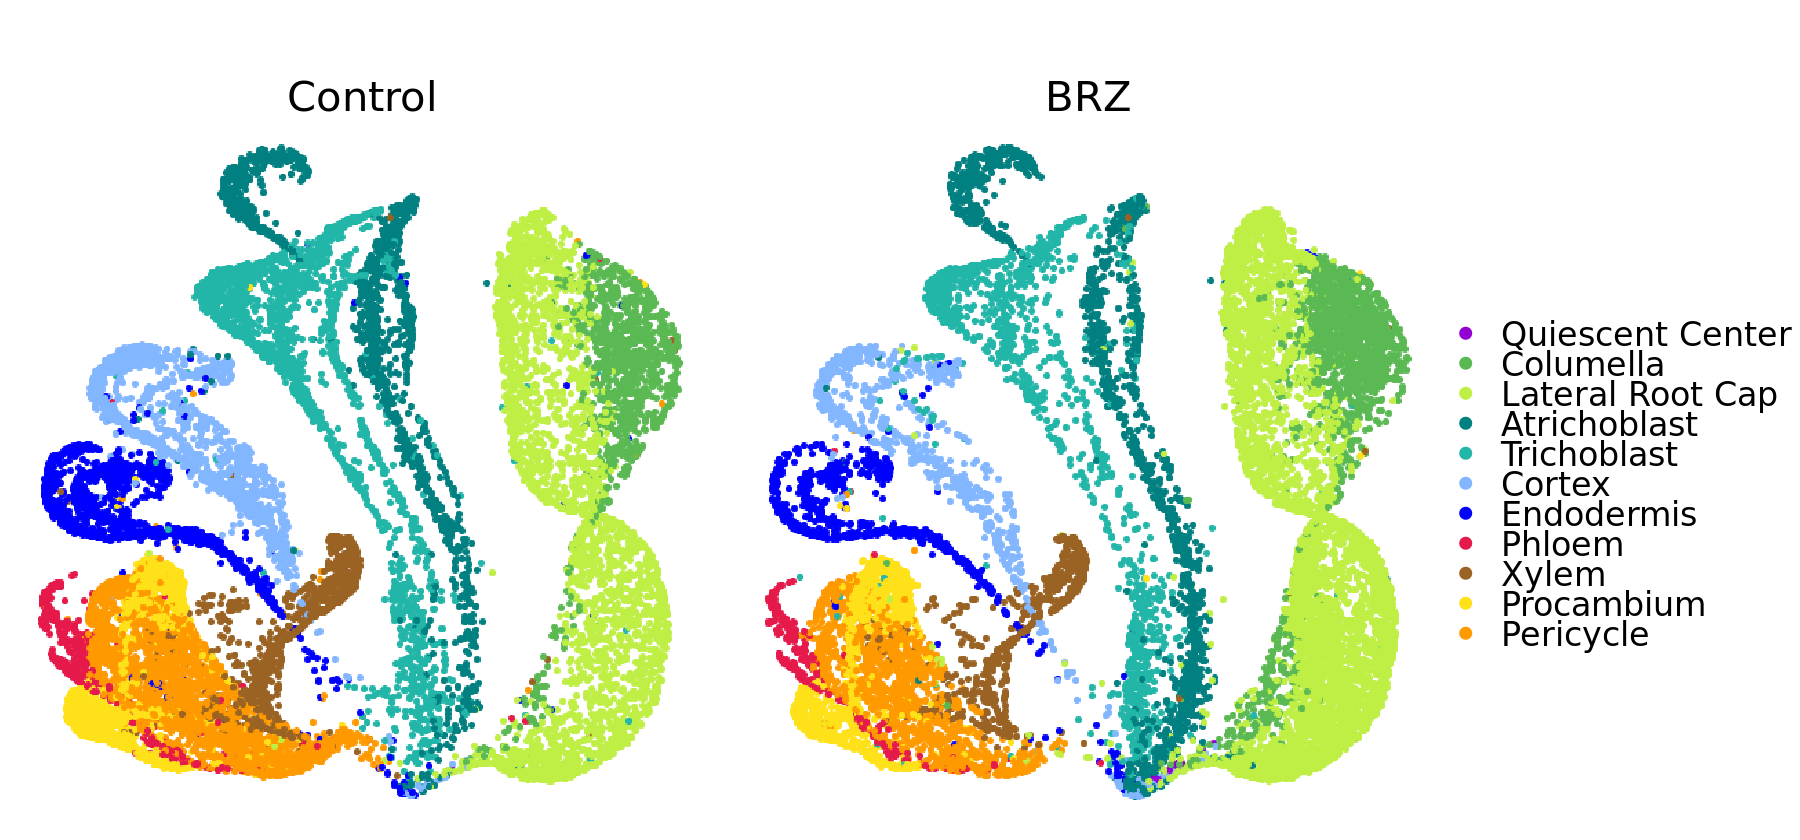

In [33]:
options(repr.plot.width=15, repr.plot.height=7)

# Plot celltype annotation Li
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400D3", "#DCD0FF","#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#E6194B", "#DD77EC", "#9A6324", "#FFE119", "#FF9900", "#FFD4E3", "#9A6324", "#DDAA6F", "#EEEEEE")
integrated.de$cell_type <- factor(integrated.de$cell_type, levels = order[sort(match(unique(integrated.de$cell_type),order))])
color <- palette[sort(match(unique(integrated.de$cell_type),order))]




(cell_umap <- DimPlot(integrated.de, reduction = "umap", group.by = "cell_type", cols = color, split.by = 'treatment', pt.size = 2, raster = T) + 
                        theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm")) + 
                         ggtitle("") +
                         theme_void(base_size = 25) &
                            theme(plot.title = element_text(hjust = 0.5)) +
theme(strip.text = NULL))

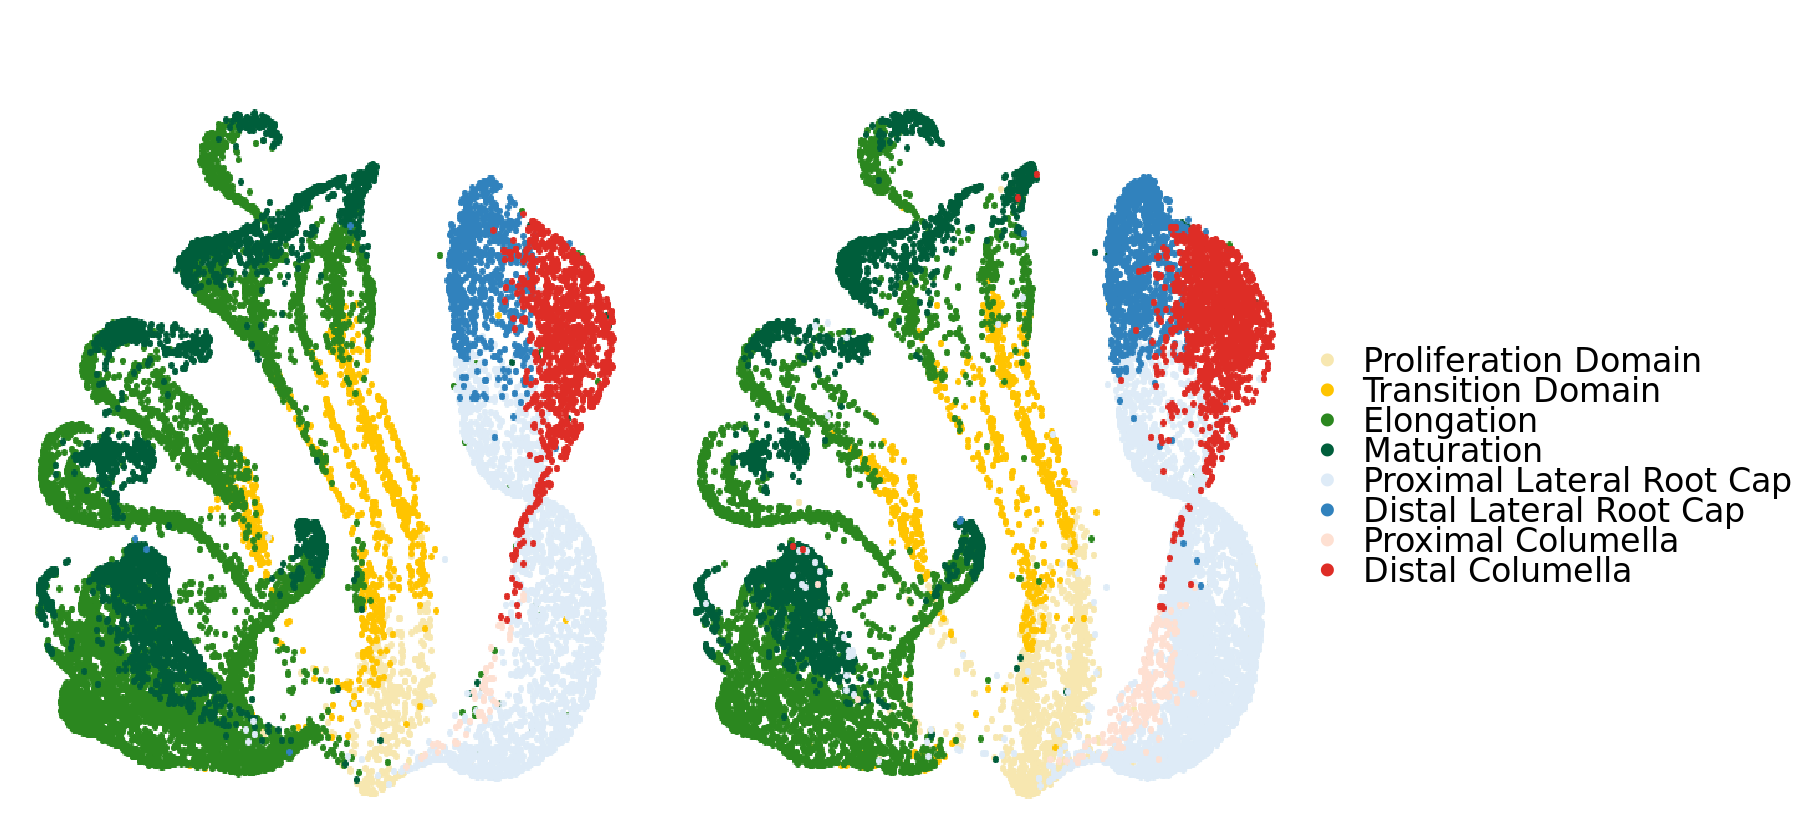

In [34]:
options(repr.plot.width=15, repr.plot.height=7)
(time_umap <-DimPlot(integrated.de, 
        group.by = "time_zone", 
order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B', "#deebf7", "#3182bd", '#fee0d2','#de2d26'),
        split.by = 'treatment', 
        pt.size = 2, 
        raster = T) +  theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm")) + 
                         ggtitle("") +
                         theme_void(base_size = 25) &
                            theme(plot.title = element_text(hjust = 0.5))+ theme(strip.text = element_text(size=0)))

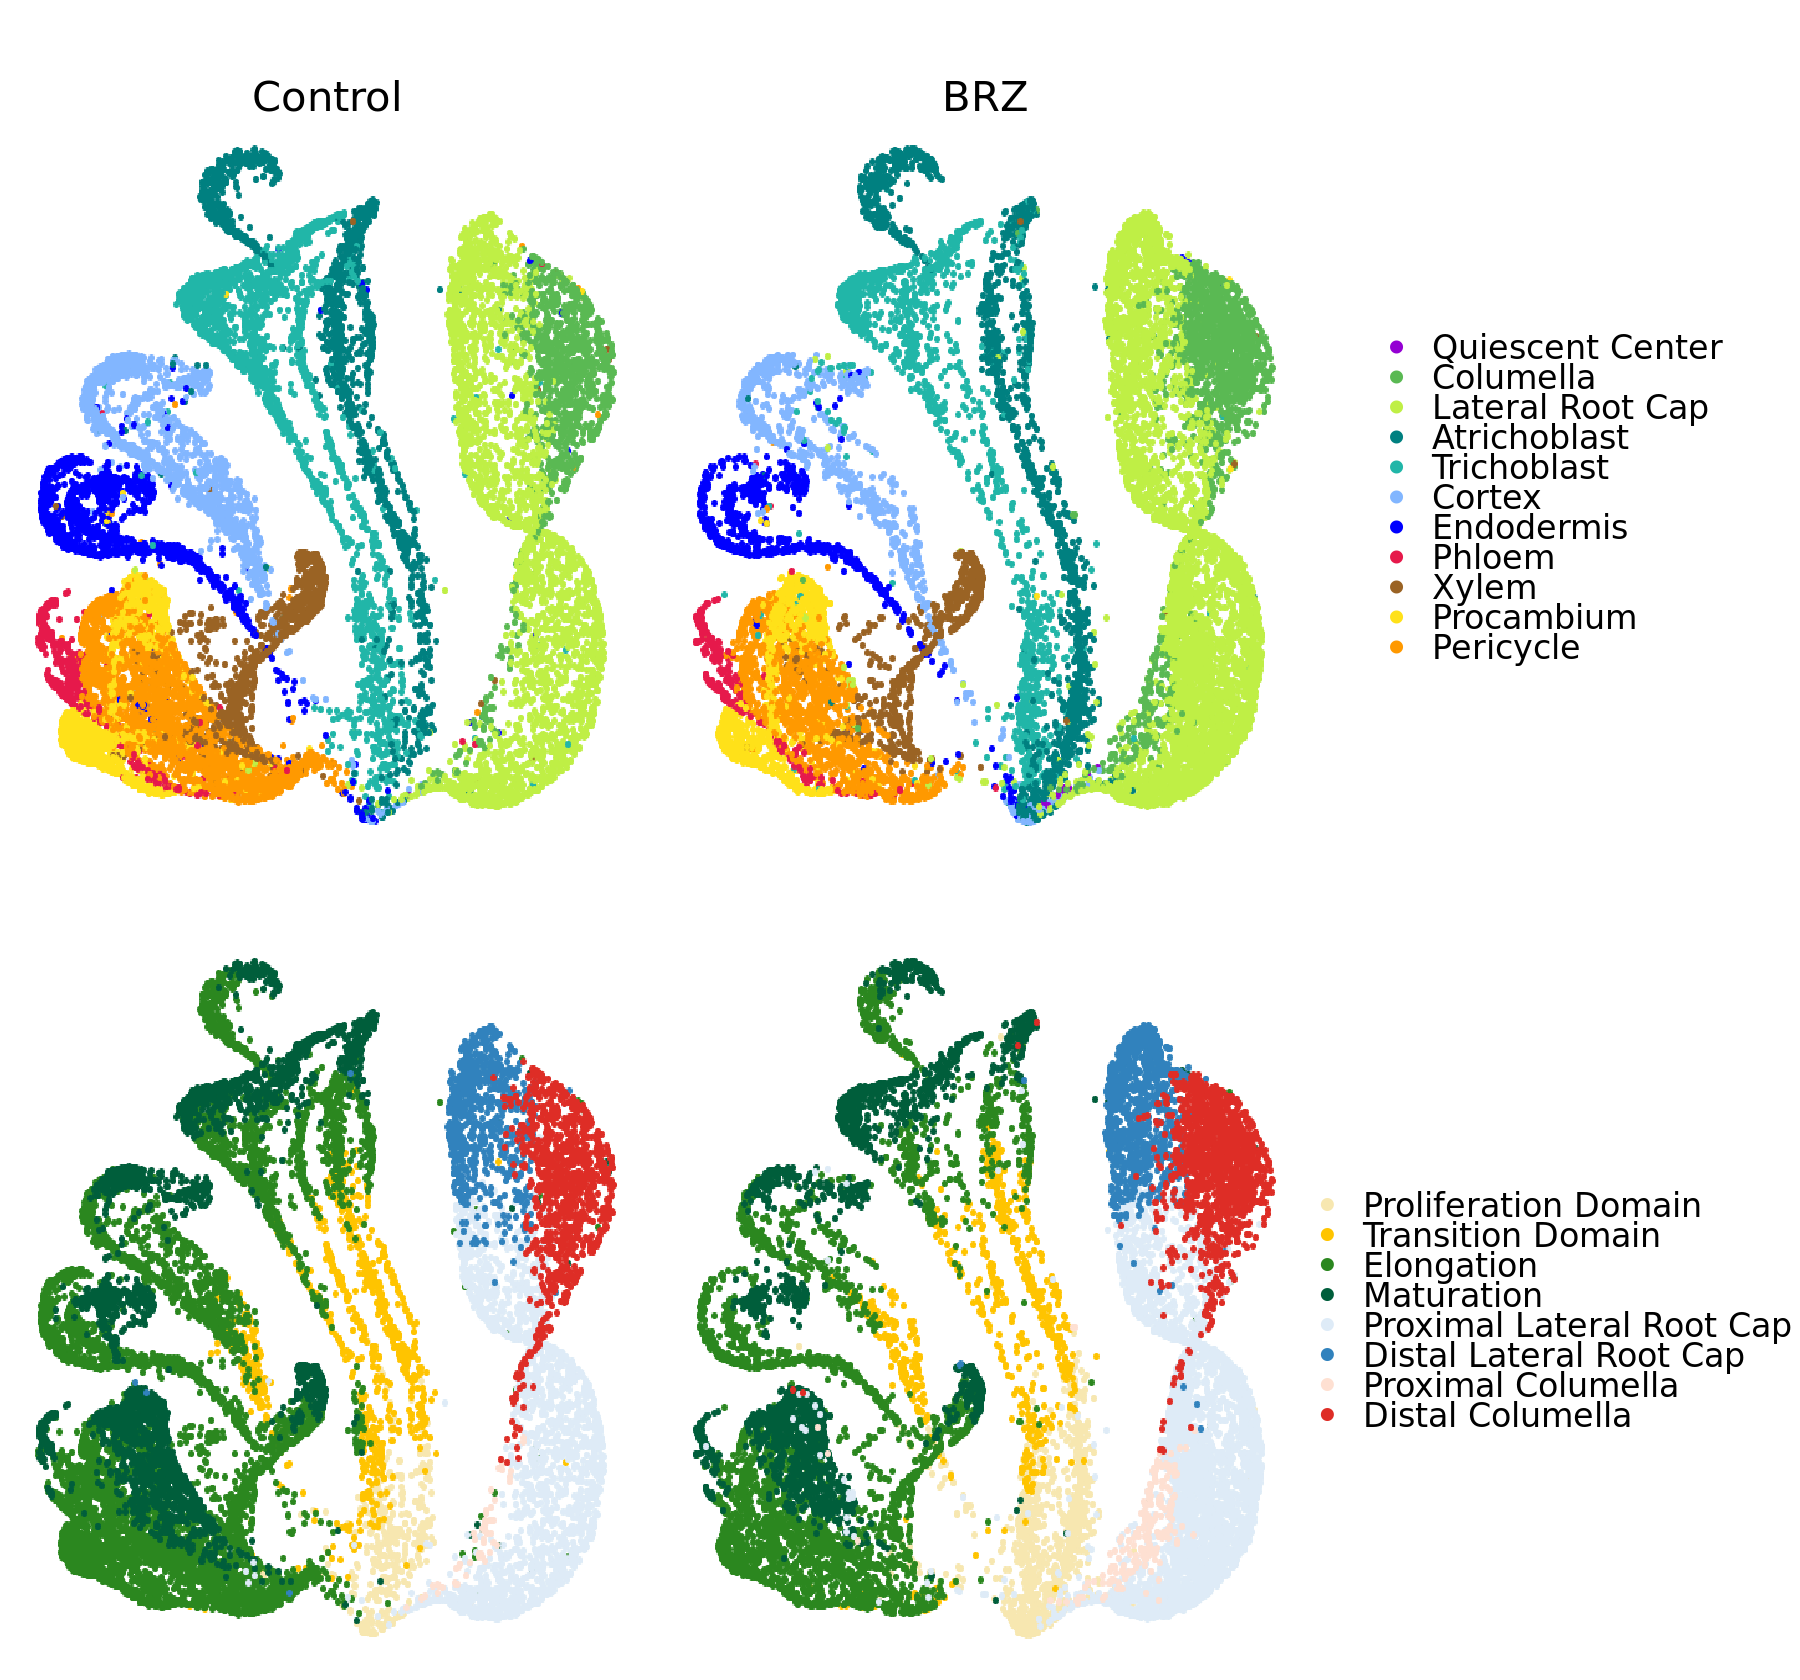

In [35]:
options(repr.plot.width=15, repr.plot.height=14)

cell_umap/time_umap

# send to BR figs repo 

ggsave("./output/BRZ_cell_time_umaps.pdf", width=15, height=14)

### Number of DEGs per subpopulation

In [36]:
nb_genes_per_clust <- sig_DE_fil  %>%
  group_by(cluster_id) %>%
  tally()



nb_de_gene_count <- sig_DE_fil %>%
  group_by(gene) %>%
  tally(name = "n_clusters_de")

 

nb_cluster_DE_sig <- left_join(sig_DE_fil, nb_de_gene_count)

# color up and down

nb_up_dn <- sig_DE_fil  %>%
  group_by(cluster_id, up_dn_label) %>%
  tally(name = "n_up_dn") %>%
left_join(nb_genes_per_clust)



Joining, by = "gene"

Joining, by = "cluster_id"



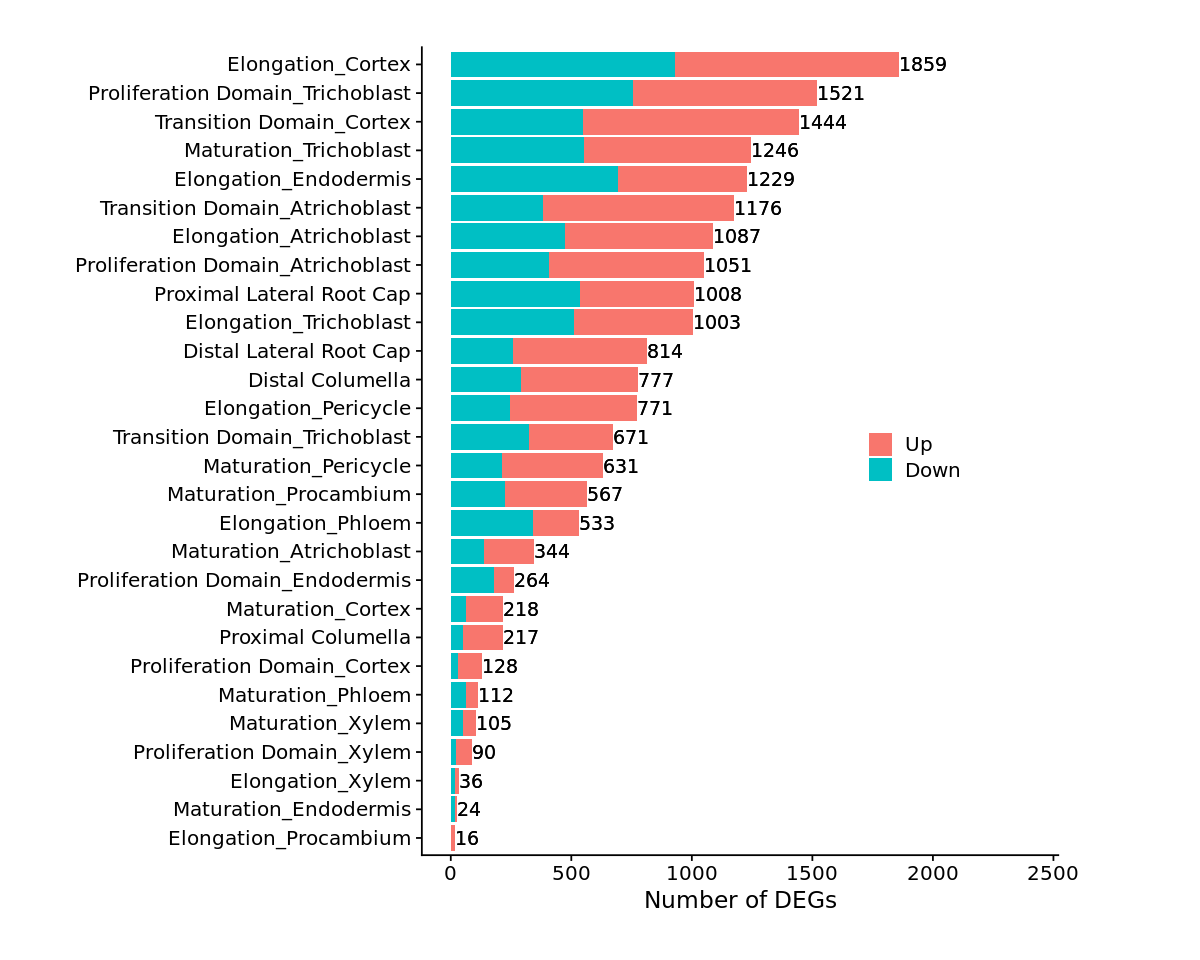

In [37]:
options(repr.plot.width=10, repr.plot.height=8)

nb_v <- ggplot(data=nb_up_dn, aes(x=reorder(cluster_id, n), y=n_up_dn, fill=factor(up_dn_label, levels=c("Up", "Down")))) +
  geom_bar(stat="identity", position="stack") + ylab("Number of DEGs") + xlab("") + 
scale_y_continuous(limits = c(0, 2400)) +
geom_text(aes(label=n, y = n), hjust=0, vjust=0.5, size=4)  + 
theme_cowplot()  +theme(plot.margin = margin(1,3,1,1, "cm"), 
                        legend.title=element_blank(), 
                       legend.position = c(0.7, 0.5))

(de_up_dn_bar_v <- nb_v + coord_flip())

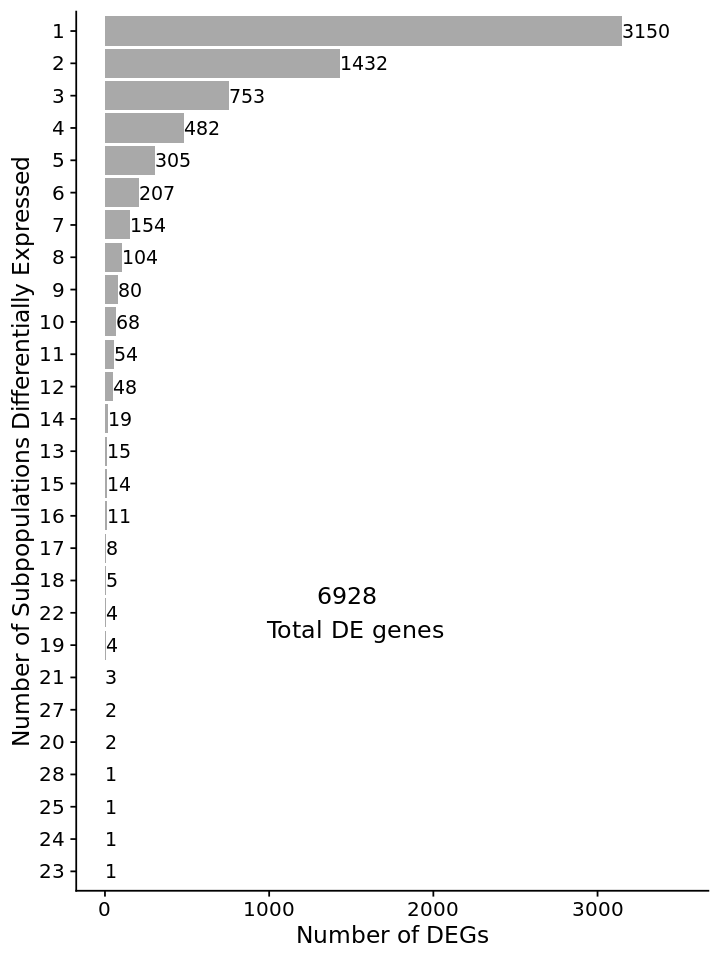

In [38]:
options(repr.plot.width=6, repr.plot.height=8)

# get number of times a gene is DE across the number of clusters
gene_de_n <- nb_de_gene_count %>%
  group_by(n_clusters_de) %>%
  tally()

total_de_gene_number <- length(unique(sig_DE_fil$gene))


total_de_gene_number_label <- paste(length(unique(sig_DE_fil$gene)), "\n Total DE genes", sep = " ")

#can toggle colors below to highlight first bar
gene_de_n$highlight <- c("yes", rep("no", (nrow(gene_de_n)-1)))

nb_gene_p3<-ggplot(data=gene_de_n, aes(x=reorder(n_clusters_de, n), y=n, fill=highlight)) +
  geom_bar(stat="identity") + 
  ylab("Number of DEGs") + 
  xlab("Number of Subpopulations Differentially Expressed") + 
  geom_text(aes(label=n), hjust=0, vjust=0.5, size=4) + 
  annotate("text", x = 9, y=1500, label=total_de_gene_number_label, size=5) + 
  scale_fill_manual(values = c("darkgrey", "darkgrey")) + 
scale_y_continuous(limits = c(0, 3500)) +
  theme(legend.position = "none") + theme_cowplot() + NoLegend()



(subpop_bar_v <- nb_gene_p3 + coord_flip())

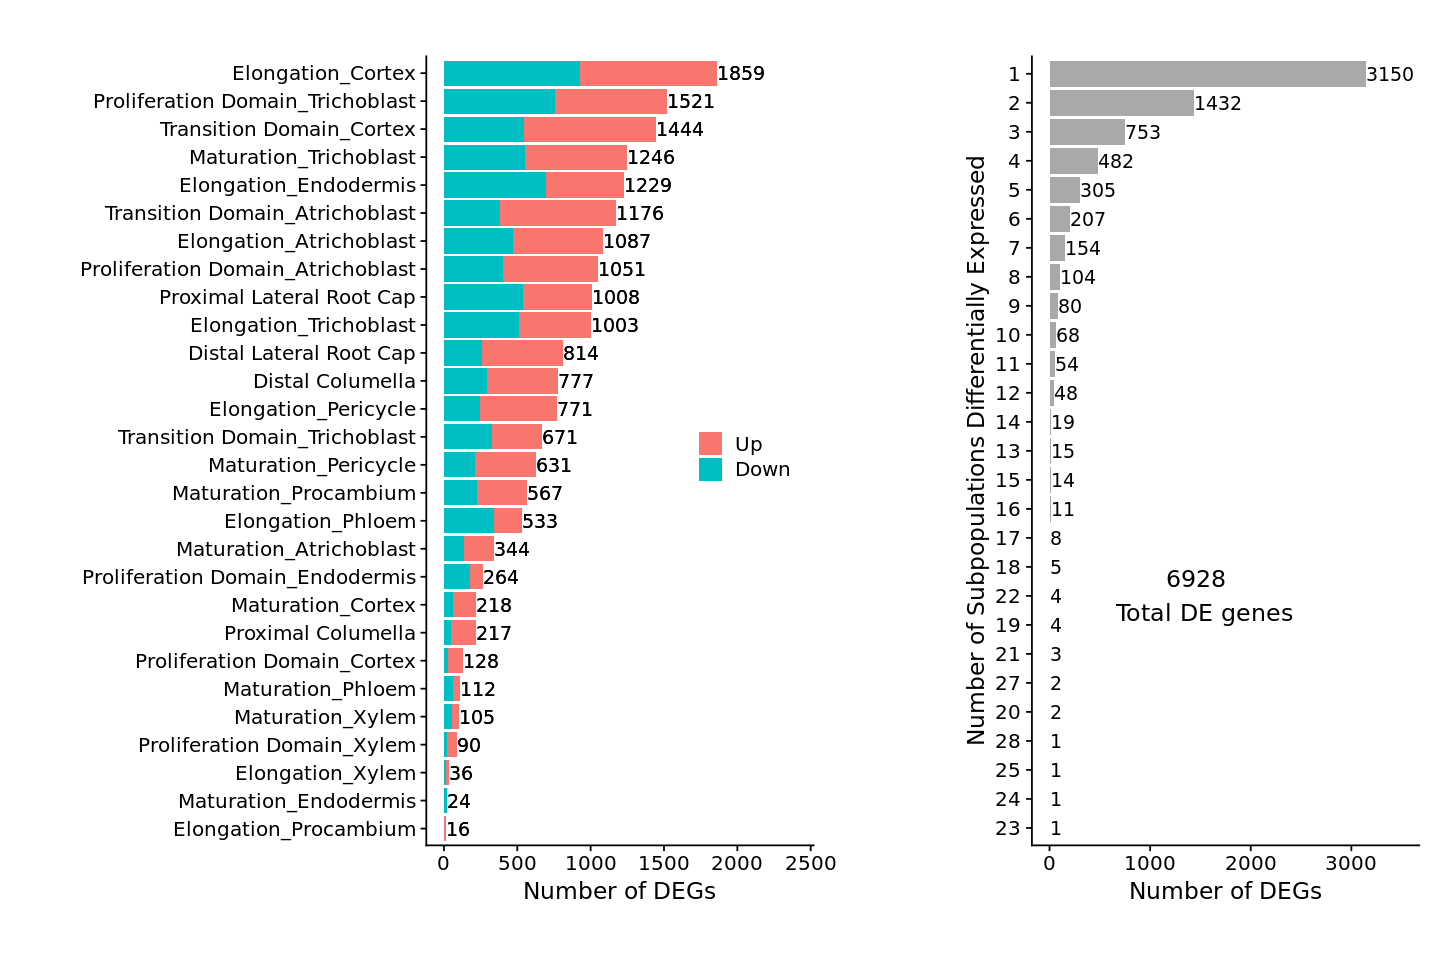

In [39]:
options(repr.plot.width=12, repr.plot.height=8)
de_up_dn_bar_v + subpop_bar_v

ggsave("./output/WT_Control_vs_WT_BRZ_vertical_num_DE_genes_w_subpop.pdf", width = 12, height = 8)

## Volcano plots with only DE genes

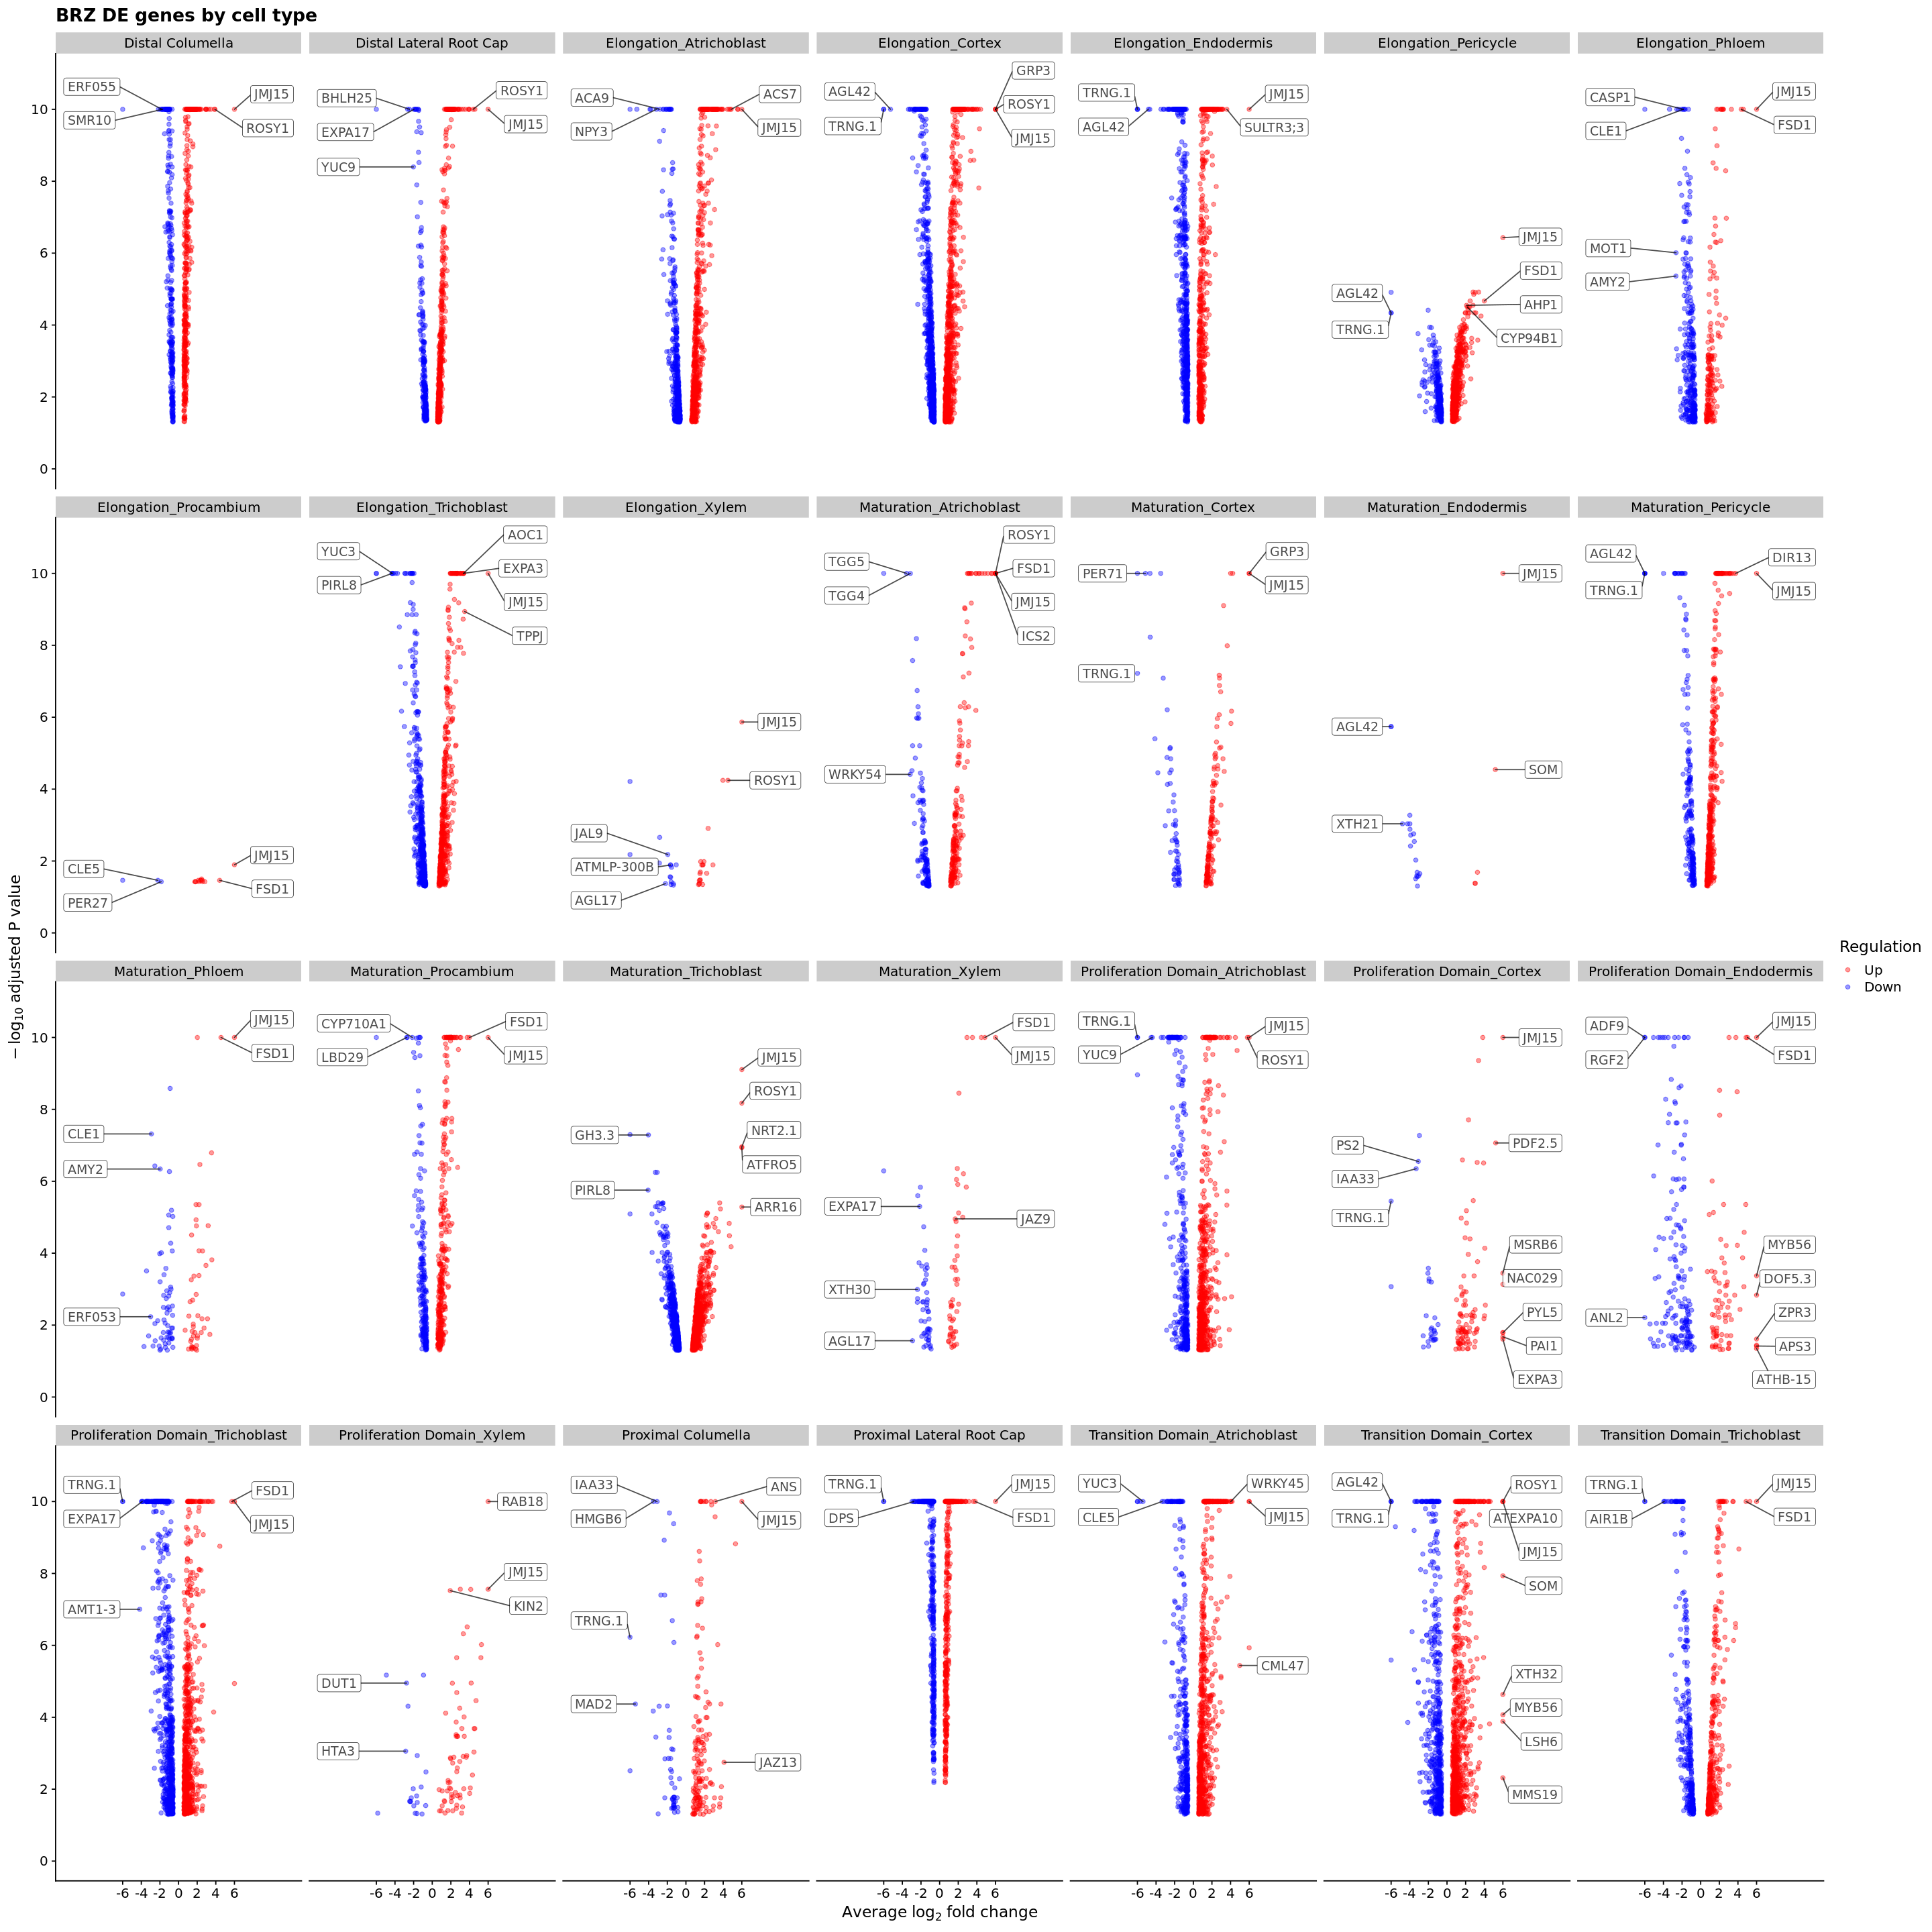

In [40]:
## Volcano plots with only DE genes

options(repr.plot.width = 24, repr.plot.height = 24)
nb_de_total_names <- sig_DE_fil

# need combo of cluster and gene 
#nb_de_total_names$sig <- nb_de_total_names$gene_id %in% nb_DE_sig$gene_id

#nb_de_total_names$known_drought <- nb_de_total_names$gene_id %in% drought_names$gene_id

# nb_de_total_names %>%
#   group_by(gene_id) %>%
#   filter(known_drought==T & sig==T) %>%
#   ungroup() %>%
#   select(gene_id) %>%
#   distinct()

nb_de_total_names <- dplyr::rename(nb_de_total_names, log2FC=logFC)

nb_de_total_names$logFDR <- -log10(nb_de_total_names$p_adj.loc)
# color up/down and facet plot 

# filter(nb_de_total, p_val_adj<=0.05) %>%
# filter(avg_logFC>=log2(1.25) | avg_logFC<=log2(3/4))

all_time_pts <- nb_de_total_names %>%
  mutate(up_dn_label = case_when(log2FC >=log2(1.25) ~ "Up",  
                                       log2FC <=log2(3/4) ~ "Down",
                                       TRUE ~ "Not DE"))
all_time_pts$up_dn_label <- factor(all_time_pts$up_dn_label, levels=c("Up", "Down", "Not DE"))


all_time_pts$sig <- all_time_pts$up_dn_label !="Not DE"
# set limits of FC and logFDR
all_time_pts_cut <- all_time_pts
# round to cutoff at 4
all_time_pts_cut$logFDR[all_time_pts_cut$logFDR>10] <- 10

# limit log2FC to 4 
all_time_pts_cut$log2FC[all_time_pts_cut$log2FC>6] <- 6
all_time_pts_cut$log2FC[all_time_pts_cut$log2FC < -6] <- -6

# # labels 
# 
# time.labs <- c("15 min", "30 min", "1 hour", "2 hour", "4 hour", "8 hour")
# names(time.labs) <- c(1, 2, 3, 4, 5, 6)

genes_w_names <- filter(all_time_pts_cut, !grepl("^AT[1-5]", Name) & sig==TRUE)

top_genes_to_label <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(10, logFDR) %>%
  top_n(2, log2FC)
top_genes_to_label2 <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(10, logFDR) %>%
  top_n(2, -log2FC)

top_genes_to_label3 <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(2, log2FC)
top_genes_to_label4 <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(2, -log2FC)

top_genes_to_label <- bind_rows(top_genes_to_label, top_genes_to_label2, top_genes_to_label3, top_genes_to_label4) %>%
  distinct()

up_genes_to_label <- filter(top_genes_to_label, log2FC>0)
down_genes_to_label <- filter(top_genes_to_label, log2FC<0)


p = ggplot(all_time_pts_cut, aes(log2FC, logFDR)) +
  geom_point(aes(col=up_dn_label), alpha = 0.4) +
  scale_color_manual(values=c("red", "blue", "black")) + 
  scale_x_continuous(limits=c(-12, 12), breaks = c(-6, -4, -2, 0, 2, 4, 6)) + scale_y_continuous(limits=c(0, 11), breaks = c(0, 2, 4, 6, 8, 10)) + 
  xlab(expression(Average~log[2]~fold~change)) + 
  ylab(expression(-log[10]~adjusted~P~value)) + 
  scale_alpha(guide="none")

all_plot <- p+ geom_label_repel(data=up_genes_to_label, 
                   aes(label=Name), 
                   size = 4, 
                   nudge_x = 11.5, 
                   direction = "y", 
                   alpha = 0.7, box.padding = 0.5) + 
  geom_label_repel(data=down_genes_to_label, 
                   aes(label=Name), 
                   size = 4, 
                   nudge_x = -11.5, 
                   direction = "y", 
                   alpha = 0.7, box.padding = 0.5) +
  labs(color = "Regulation") + ggtitle("") + theme_minimal() + theme(plot.title = element_text(hjust = 0.5))



all_plot + facet_wrap(~ cluster_id, nrow = 4) + ggtitle("BRZ DE genes by cell type") + theme_cowplot()


## Up vs down GO enrichment and overlap analysis

In [41]:
markers_sel <- select(sig_DE_fil, gene, clust_up_dn)

markers_list <- split(markers_sel, f=markers_sel$clust_up_dn)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))
                         
cluster_GO <- gost(markers_list, organism = "athaliana", correction_method = "fdr", significant = F, multi_query = F)

cluster_GO_df <- cluster_GO[[1]]

cluster_GO_sig <- filter(cluster_GO_df, p_value<=0.01)

In [42]:
# top  terms for each cluster

cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=8) %>%
  group_by(query) %>%
  top_n(1, wt = -p_value) %>%
  arrange(desc(p_value)) -> top_GO

GO_n <- cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=8) %>%
  group_by(term_id) %>%
  tally() %>%
  arrange(desc(n))


GO_n <- dplyr::rename(GO_n, "n_clusters"=n)

cluster_GO_sig_n <- left_join(cluster_GO_sig, GO_n)

# get all terms for the top ones so that all clusters have values

top_GO_all <- filter(cluster_GO_df, term_id %in% top_GO$term_id)


#spread and plot


top_GO_sel <- select(top_GO_all, query, p_value, term_id, term_name)

spread_GO <- spread(top_GO_sel, key = query, p_value)

spread_GO[is.na(spread_GO)] <- 1

spread_GO_m <- as.matrix(-log10(spread_GO[3:ncol(spread_GO)]))
rownames(spread_GO_m) <- spread_GO$term_name


spread_GO_m_t <- t(spread_GO_m)

GO_hm_t <- Heatmap(spread_GO_m_t, 
                 name = "-log10_pval", 
                 heatmap_legend_param = list(title_position="leftcenter-rot", color_bar = "continuous"), 
                 col = colorRamp2(c(0, 20), c("beige", "darkgreen")), 
                 cluster_rows = T, 
                 cluster_columns = T, 
                 use_raster= FALSE, 
                 show_column_names = TRUE, 
                 show_row_names = TRUE, 
                 show_row_dend = TRUE, 
                 show_column_dend = TRUE,
                 column_names_rot = 45,
                 clustering_distance_columns = "pearson", 
                 clustering_distance_rows = "pearson",
                 row_names_gp = gpar(fontsize = 14), 
                column_names_gp = gpar(fontsize = 14)) 

Joining, by = "term_id"



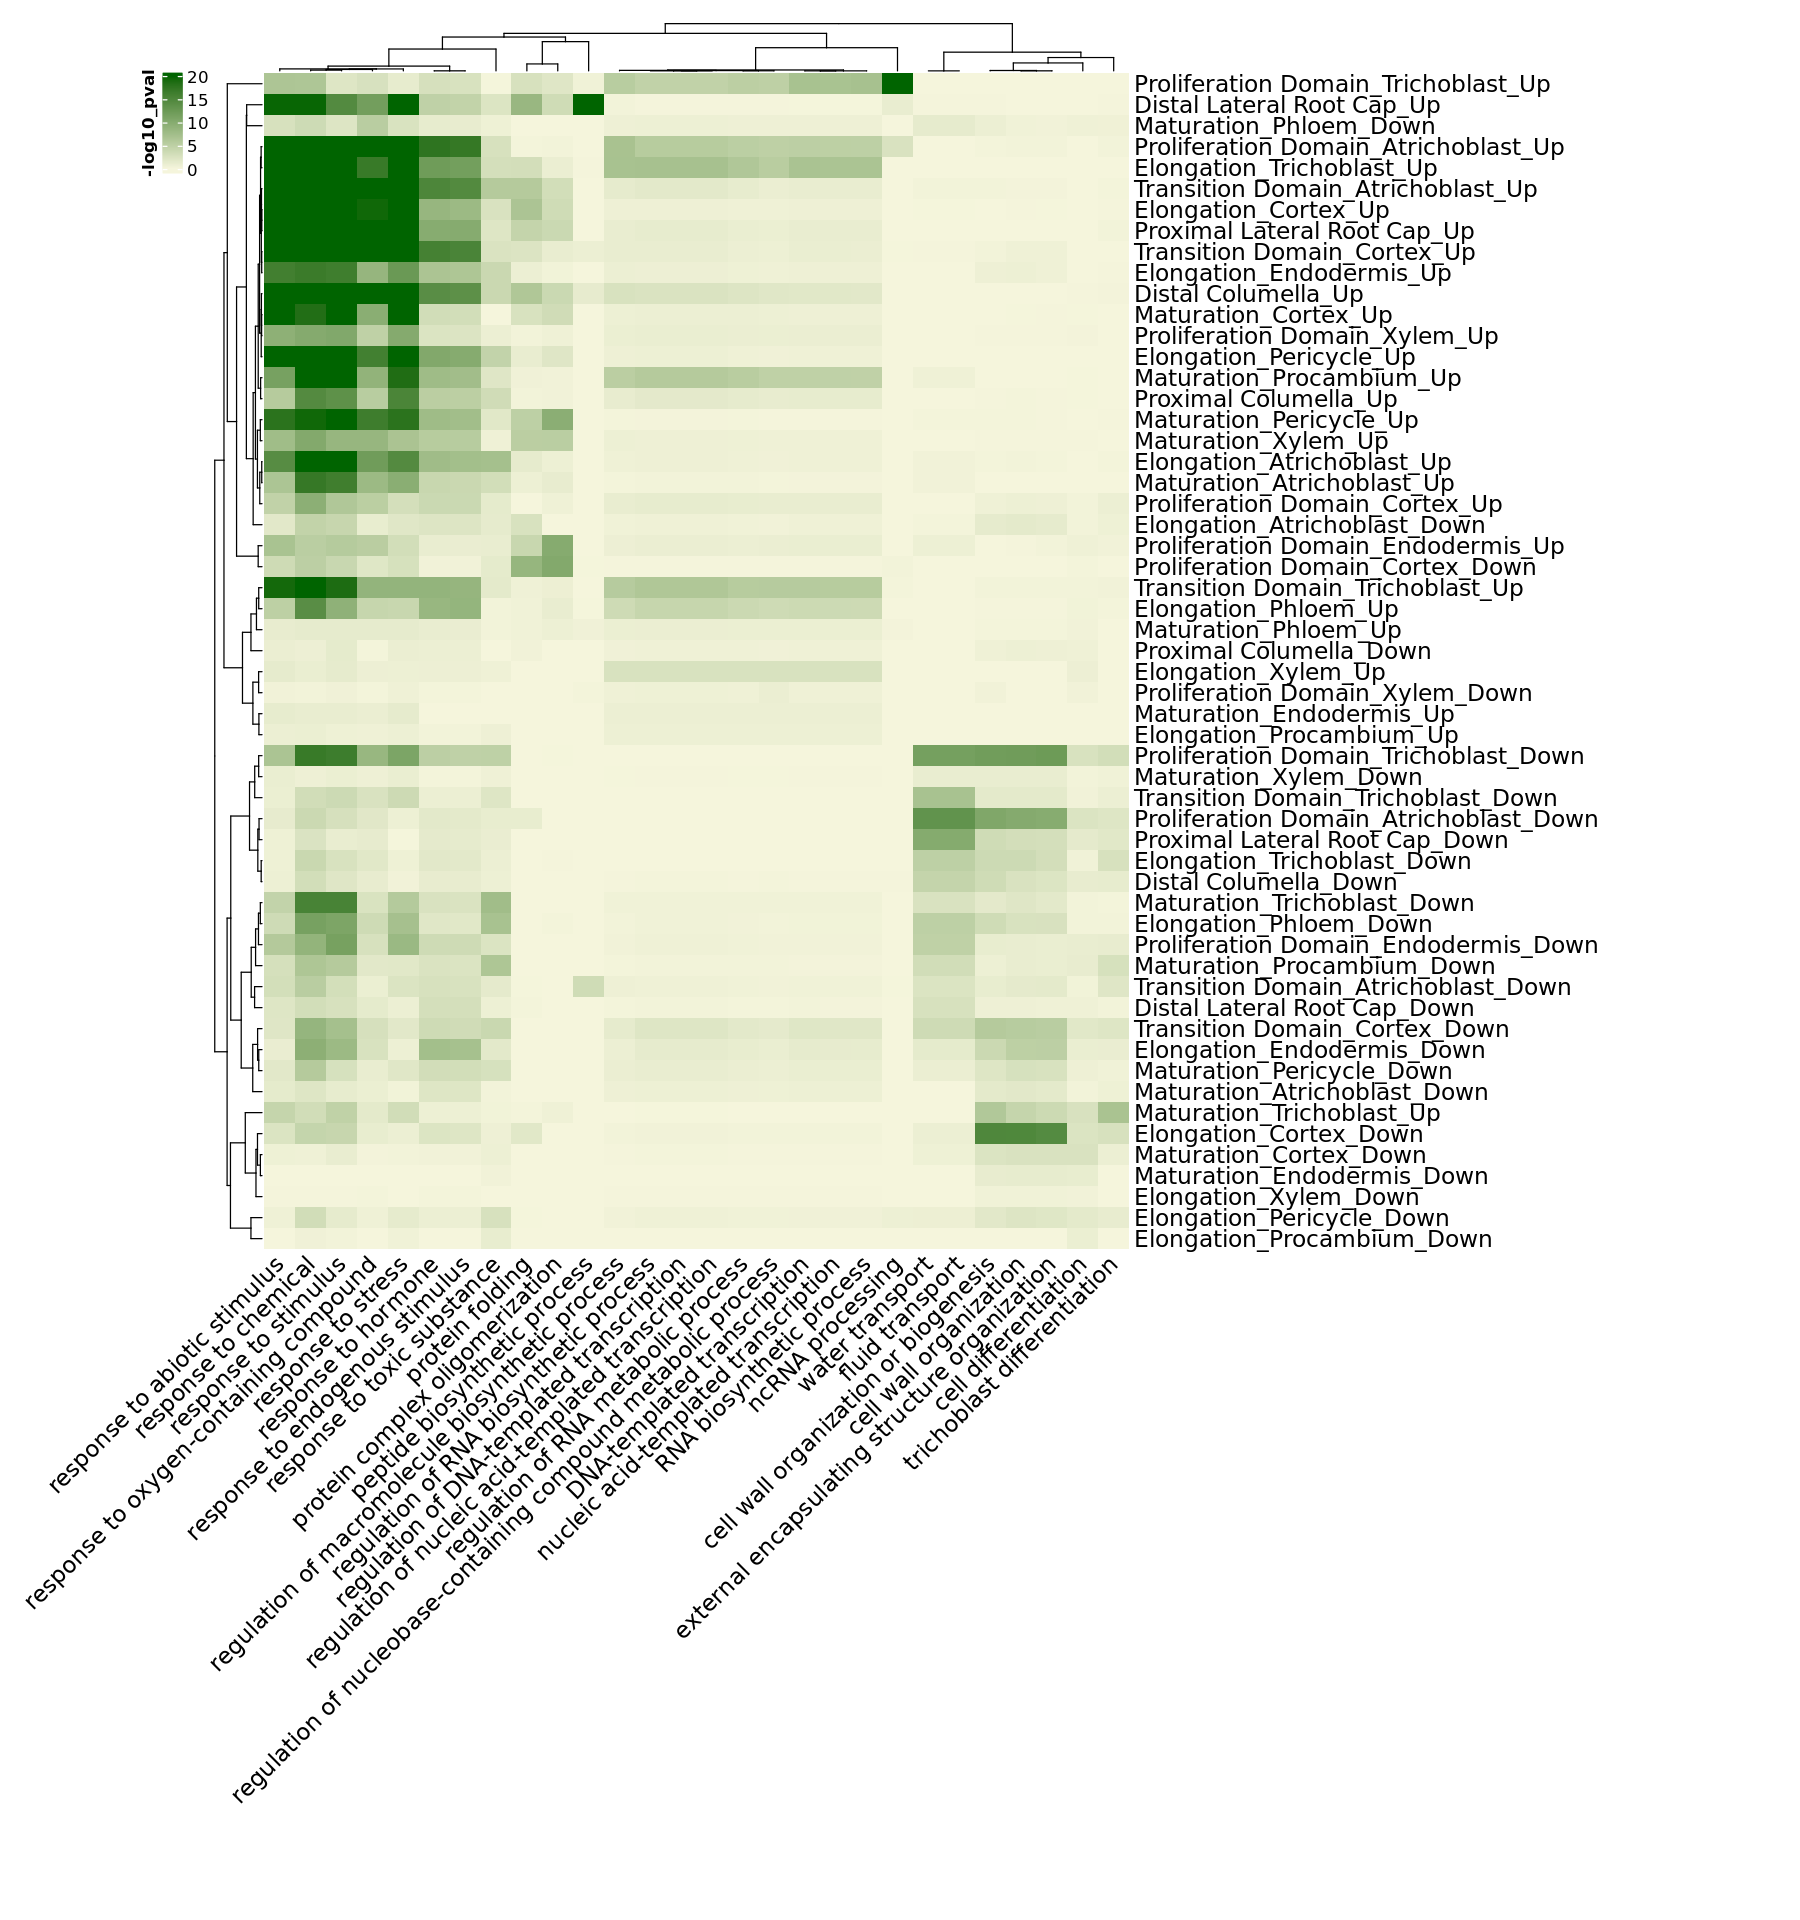

In [43]:
options(repr.plot.width = 15, repr.plot.height = 16)

# padding - bottom, left, top, right
draw(GO_hm_t, padding = unit(c(80, 30, 5, 80), "mm"), heatmap_legend_side = "left")

In [44]:
pdf("./output/BRZ_GO_hm.pdf", width = 15, height = 16)


# padding - bottom, left, top, right
draw(GO_hm_t, padding = unit(c(80, 30, 5, 80), "mm"), heatmap_legend_side = "left")

dev.off()

png 
  2

In [45]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/tmnolan7/anaconda3/envs/r_4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] future_1.22.1               scran_1.16.0               
 [3] SingleCellExperiment_1.12.0 SummarizedExperiment_1.20.0
 [5] Biobase_2.50.0              GenomicRanges_1.42.0       
 [7] GenomeInfoDb_1.26.7         IRanges_2.24.1             
 [9] S4Vectors_0.28.1 